In [6]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torchvision.datasets as datasets
import sys
import numpy as np
import torch.utils.data as utils
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pickle as pkl

from os.path import join as oj
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from torch.utils.data import Subset

import torch
import torchvision
import torchvision.datasets as datasets
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as utils

import csv
import numpy as np
sys.path.append("../../fit")
from tqdm import tqdm_notebook
import cd
from shutil import copyfile
from os.path import join as oj
from PIL import Image
from tqdm import tqdm
from skimage.color import rgb2gray

from torch import nn    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
sys.path.append("../../../pytorch-cnn-visualizations/src")
from gradcam import GradCam

In [8]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

In [176]:
save_path = "../../results_for_export"
device = torch.device("cuda")
import torchvision.models as models

model = models.vgg16(pretrained=True).to(device)
model.classifier[-1] = nn.Linear(4096, 2)
model.classifier.load_state_dict(torch.load('../old_feature_models/30446737273071054815.pt'))
model = model.to(device).eval()
model = model.cuda()

In [162]:
# load the two imgs
data_path = "../../../../datasets"
img_path = oj(data_path, "ISIC/raw_data/not_cancer")
seg_path  = oj(data_path, "ISIC/segmentation")

In [190]:
os.listdir(seg_path)[:20]

['ISIC_0000557.jpg',
 'ISIC_0000558.jpg',
 'ISIC_0000559.jpg',
 'ISIC_0000560.jpg',
 'ISIC_0000561.jpg',
 'ISIC_0000562.jpg',
 'ISIC_0000563.jpg',
 'ISIC_0000564.jpg',
 'ISIC_0000565.jpg',
 'ISIC_0000566.jpg',
 'ISIC_0000567.jpg',
 'ISIC_0000568.jpg',
 'ISIC_0000569.jpg',
 'ISIC_0000570.jpg',
 'ISIC_0000572.jpg',
 'ISIC_0000573.jpg',
 'ISIC_0000574.jpg',
 'ISIC_0000575.jpg',
 'ISIC_0000576.jpg',
 'ISIC_0000577.jpg']

# Check that it learned the bad

In [196]:
img = Image.open(oj(img_path, "ISIC_0000570.jpg"))
img_np = np.asarray(img)/255.0
img.close()

In [197]:
seg = Image.open(oj(seg_path, "ISIC_0000570.jpg"))
seg_np = np.asarray(seg)[:,:,0]
seg_np = (seg_np > seg_np.mean())
seg.close()

In [198]:
from skimage.morphology import dilation
from skimage.morphology import square
seg_np_open = dilation(seg_np.astype(np.uint8),square(15))

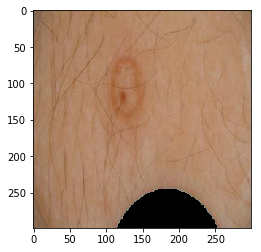

In [200]:
plt.imshow(img_np * (1- seg_np).astype(np.float32)[:,:,None])

In [177]:
torch_img = torch.from_numpy(((img_np - mean)/std).swapaxes(0,2).swapaxes(1,2)).float().cuda()
model(torch_img[None, :])

tensor([[10.0599, -9.6964]], device='cuda:0', grad_fn=<AddmmBackward>)

In [172]:
out = cd.cd_track_vgg(seg_np[None, :], torch_img[None, :].cuda(), model.cuda())
print("Relevant:")
print(out[0])
print("Irrelevant:")
print(out[1])

Relevant:
tensor([[ 9.5659, -4.2133]], device='cuda:0', grad_fn=<AddBackward0>)
Irrelevant:
tensor([[24.4339, 14.1435]], device='cuda:0', grad_fn=<AddBackward0>)


In [173]:
not_cancer_cd = torch.nn.functional.softmax(torch.abs(torch.cat((out[0][0][1][None,], out[1][0][1][None,]),dim=0).data))
cancer_cd = torch.nn.functional.softmax(torch.abs(torch.cat((out[0][0][0][None,], out[1][0][0][None,]),dim=0).data))

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [174]:
test_out.mean()

0.5845113045218088

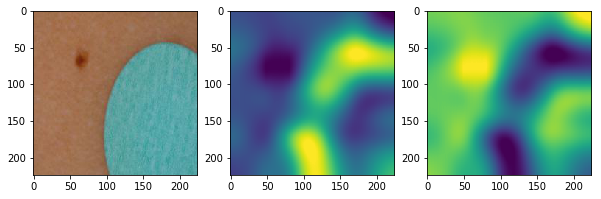

In [178]:
model_gradCAM = GradCam(model.cpu(),30)

fig, axes = plt.subplots(ncols =3, figsize = (10, 5))
axes[0].imshow(img_np[50:274, 50:274])
test_out = model_gradCAM.generate_cam(torch_img[None, :,50:274, 50:274].cpu(), target_class= 0)

axes[1].imshow(test_out)
test_out = model_gradCAM.generate_cam(torch_img[None, :,50:274, 50:274].cpu(), target_class= 1)

axes[2].imshow(test_out)
# GradCAM agrees that this is good

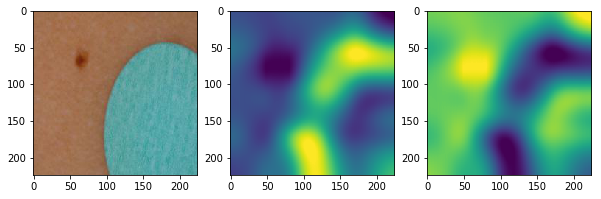

In [169]:
model_gradCAM = GradCam(model.cpu(),30)

fig, axes = plt.subplots(ncols =3, figsize = (10, 5))
axes[0].imshow(img_np[50:274, 50:274])
test_out = model_gradCAM.generate_cam(torch_img[None, :,50:274, 50:274].cpu(), target_class= 0)

axes[1].imshow(test_out)
test_out = model_gradCAM.generate_cam(torch_img[None, :,50:274, 50:274].cpu(), target_class= 1)

axes[2].imshow(test_out)
# GradCAM agrees that this is good

In [ ]:
# Extract features, extract 